## Курс Специализация Data Science Дипломный проект. Бриф учебного кейса
### «Модель прогнозирования стоимости жилья для агентства недвижимости»


#### создание модели

Будем строить следующие модели:
*  LinearRegression
*  RandomForestRegressor
*  ElasticNetCV
*  LightGBMRegressor
*  CatBoostRegressor

Оценивать модели будем с помощью метрик MSE, MAE, R2.

In [175]:
import random
import numpy as np 
import pandas as pd 
import sys
import optuna
import re
import pickle
import lightgbm as lgb 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn import metrics
from tqdm.notebook import tqdm
from category_encoders import TargetEncoder, CatBoostEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [176]:
data = pd.read_csv('data/data_for_model.csv')
display(data.head())
data.info()

,status,propertyType,baths,fireplace,city,sqft,zipcode,state,target,pool,Year built,Heating,Cooling,Parking,school_ratimg_mean,school_distance_mean,lat,lng
0,Active,single_family,4,1,Southern Pines,2900,28387,NC,418000,0,2019,1,0,0,5.2000,5.5375,35.136024,-79.366937
1,For Sale,single_family,3,0,Spokane Valley,1947,99216,WA,310000,0,2019,0,0,0,4.0000,1.3267,47.699620,-117.231130
2,For Sale,single_family,2,1,Los Angeles,3000,90049,CA,2895000,1,1961,1,1,1,6.6667,1.9600,34.071553,-118.500812
3,For Sale,single_family,8,1,Dallas,6457,75205,TX,2395000,0,2006,1,1,1,9.2500,0.7525,32.834674,-96.807835
4,For Sale,townhouse,0,0,Philadelphia,897,19145,PA,209000,0,1920,1,1,0,0.0000,0.0000,39.932968,-75.192067


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315567 entries, 0 to 315566
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                315567 non-null  object 
 1   propertyType          315567 non-null  object 
 2   baths                 315567 non-null  int64  
 3   fireplace             315567 non-null  int64  
 4   city                  315567 non-null  object 
 5   sqft                  315567 non-null  int64  
 6   zipcode               315567 non-null  object 
 7   state                 315567 non-null  object 
 8   target                315567 non-null  int64  
 9   pool                  315567 non-null  int64  
 10  Year built            315567 non-null  object 
 11  Heating               315567 non-null  int64  
 12  Cooling               315567 non-null  int64  
 13  Parking               315567 non-null  int64  
 14  school_ratimg_mean    315567 non-null  float64
 15  

In [177]:
# список категориальных признаков:
catfeatures = ['status','city','zipcode','state','propertyType','Year built']
 
# список числовых признаков:
numfeatures = ['baths', 'sqft' , 'target', 'school_ratimg_mean', 'school_distance_mean', 'lat', 'lng']

In [178]:
print('Количество уникальных значений','\n', data[catfeatures].nunique())

Количество уникальных значений 
 status            15
city            1713
zipcode         4388
state             35
propertyType      21
Year built       219
dtype: int64


Кодируем категориальные признаки используя OneHot и Label Encoder.

In [179]:
data1 = data.copy()
data1['propertyType'] = data1['propertyType'].str.replace(' ', '')
labelencoder_city = LabelEncoder()
labelencoder_zipcode = LabelEncoder()
labelencoder_state = LabelEncoder()
labelencoder_Year = LabelEncoder()
onehotencoder_status = OneHotEncoder(sparse=False)
onehotencoder_propertyType = OneHotEncoder(sparse=False)
encoded_df_status = pd.DataFrame(onehotencoder_status.fit_transform(data1[['status']]))
encoded_df_status.columns = onehotencoder_status.get_feature_names_out()
encoded_df_propertyType = pd.DataFrame(onehotencoder_propertyType.fit_transform(data1[['propertyType']]))
encoded_df_propertyType.columns = onehotencoder_propertyType.get_feature_names_out()
data1 = data1.join(encoded_df_status)
data1 = data1.join(encoded_df_propertyType)
data1.drop(['status', 'propertyType'], axis = 1, inplace = True)
data1.loc[:, 'city'] = labelencoder_city.fit_transform(data1.loc[:, 'city'])
data1.loc[:, 'zipcode'] = labelencoder_zipcode.fit_transform(data1.loc[:, 'zipcode'])
data1.loc[:, 'state'] = labelencoder_state.fit_transform(data1.loc[:, 'state'])
data1.loc[:, 'Year built'] = labelencoder_Year.fit_transform(data1.loc[:, 'Year built'])
data1['city'] = data1['city'].astype(int)
data1['zipcode'] = data1['zipcode'].astype(int)
data1['state'] = data1['state'].astype(int)
data1['Year built'] = data1['Year built'].astype(int)

In [180]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315567 entries, 0 to 315566
Data columns (total 51 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   baths                                      315567 non-null  int64  
 1   fireplace                                  315567 non-null  int64  
 2   city                                       315567 non-null  int64  
 3   sqft                                       315567 non-null  int64  
 4   zipcode                                    315567 non-null  int64  
 5   state                                      315567 non-null  int64  
 6   target                                     315567 non-null  int64  
 7   pool                                       315567 non-null  int64  
 8   Year built                                 315567 non-null  int64  
 9   Heating                                    315567 non-null  int64  
 10  Cooling 

Из наименований столбцов удаляем все символы кроме букв латинского алфавита.

In [181]:
data1 = data1.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [182]:
# список категориальных признаков:
catfeatures = ['status','city','zipcode','state','propertyType','Yearbuilt']
 
# список числовых признаков:
numfeatures = ['baths', 'sqft' , 'target', 'school_ratimg_mean', 'school_distance_mean', 'lat', 'lng']


Проверяем как лучше обработать числовые признаки.

In [183]:
data_scaler_mm = data1[numfeatures]
scaler = MinMaxScaler()
data_sc = scaler.fit_transform(data_scaler_mm)
data_mm = pd.DataFrame(data_sc, columns = numfeatures)

In [184]:
data_mm.describe()

,baths,sqft,target,school_ratimg_mean,school_distance_mean,lat,lng
count,315567.000000,315567.000000,315567.000000,315567.000000,315567.000000,315567.000000,315567.000000
mean,0.029272,0.000423,0.003886,0.512564,0.060256,0.607220,0.251912
std,0.022125,0.003815,0.010224,0.200301,0.067264,0.076177,0.045267
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.026316,0.000184,0.001284,0.366670,0.022712,0.549510,0.231121
50%,0.026316,0.000261,0.002041,0.500000,0.037669,0.596972,0.272782
75%,0.039474,0.000372,0.003587,0.650000,0.067425,0.674084,0.285578
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [185]:
data_std_scaler  = data1[numfeatures]
scaler1 = StandardScaler()
data_sc1 = scaler1.fit_transform(data_std_scaler)
data_std = pd.DataFrame(data_sc1, columns = numfeatures)

In [186]:
data_std.describe()

,baths,sqft,target,school_ratimg_mean,school_distance_mean,lat,lng
count,3.155670e+05,3.155670e+05,3.155670e+05,3.155670e+05,3.155670e+05,3.155670e+05,3.155670e+05
mean,1.248984e-16,-5.246317e-18,2.166076e-17,7.691484e-16,1.159143e-16,-5.095683e-16,1.562873e-15
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.323038e+00,-1.107889e-01,-3.800808e-01,-2.558977e+00,-8.958205e-01,-7.971231e+00,-5.564974e+00
25%,-1.336217e-01,-6.268480e-02,-2.544626e-01,-7.283756e-01,-5.581614e-01,-7.575756e-01,-4.592976e-01
50%,-1.336217e-01,-4.246551e-02,-1.804196e-01,-6.272501e-02,-3.358005e-01,-1.345270e-01,4.610332e-01
75%,4.610865e-01,-1.328455e-02,-2.919169e-02,6.861506e-01,1.065823e-01,8.777487e-01,7.437124e-01
max,4.387478e+01,2.620206e+02,9.743308e+01,2.433527e+00,1.397106e+01,5.156192e+00,1.652598e+01


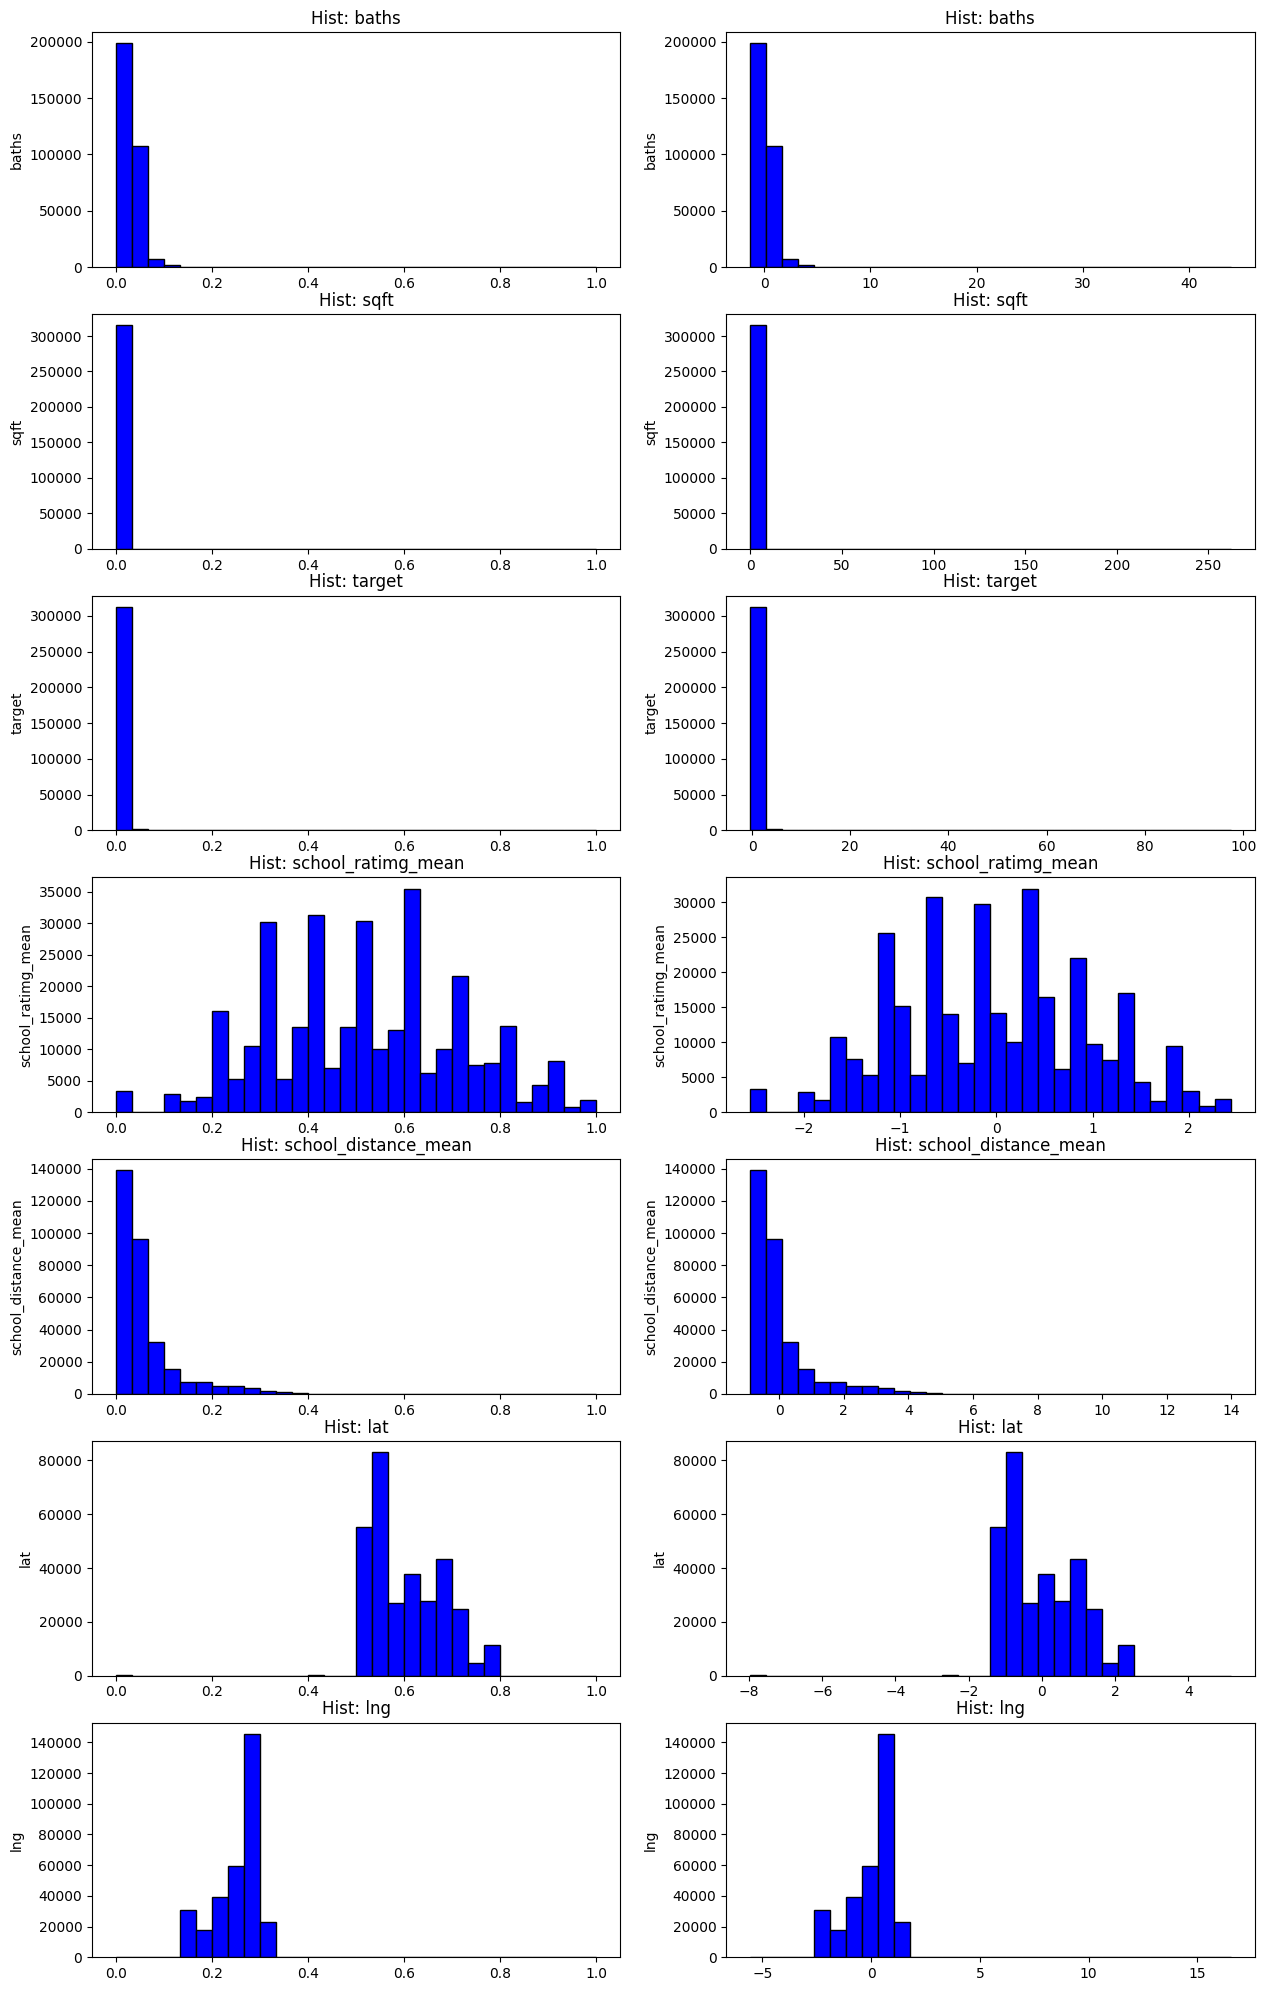

In [187]:
fig, axes = plt.subplots(7, 2, figsize=(15, 25)) # фигура + n х 1 координатных плоскостей
for i, feature in enumerate(numfeatures): #i- индекс, feature - название признака в таблице
    
    axes[i][0].hist(data_mm[feature], color = 'blue', edgecolor = 'black', bins = 30)
    axes[i][1].hist(data_std[feature], color = 'blue', edgecolor = 'black', bins = 30)
    #axes[i].boxplot(data[feature],vert=False)
    axes[i][0].set_title(f'Hist: {feature}')
    axes[i][0].set_ylabel(feature)
    axes[i][1].set_title(f'Hist: {feature}')
    axes[i][1].set_ylabel(feature)

plt.show()

In [188]:

for column in numfeatures:
        
        data1[column] = data1[column].apply(lambda x: abs(x))
        cons = 1e-1
        data1[column] = np.log(data1[column] + cons)

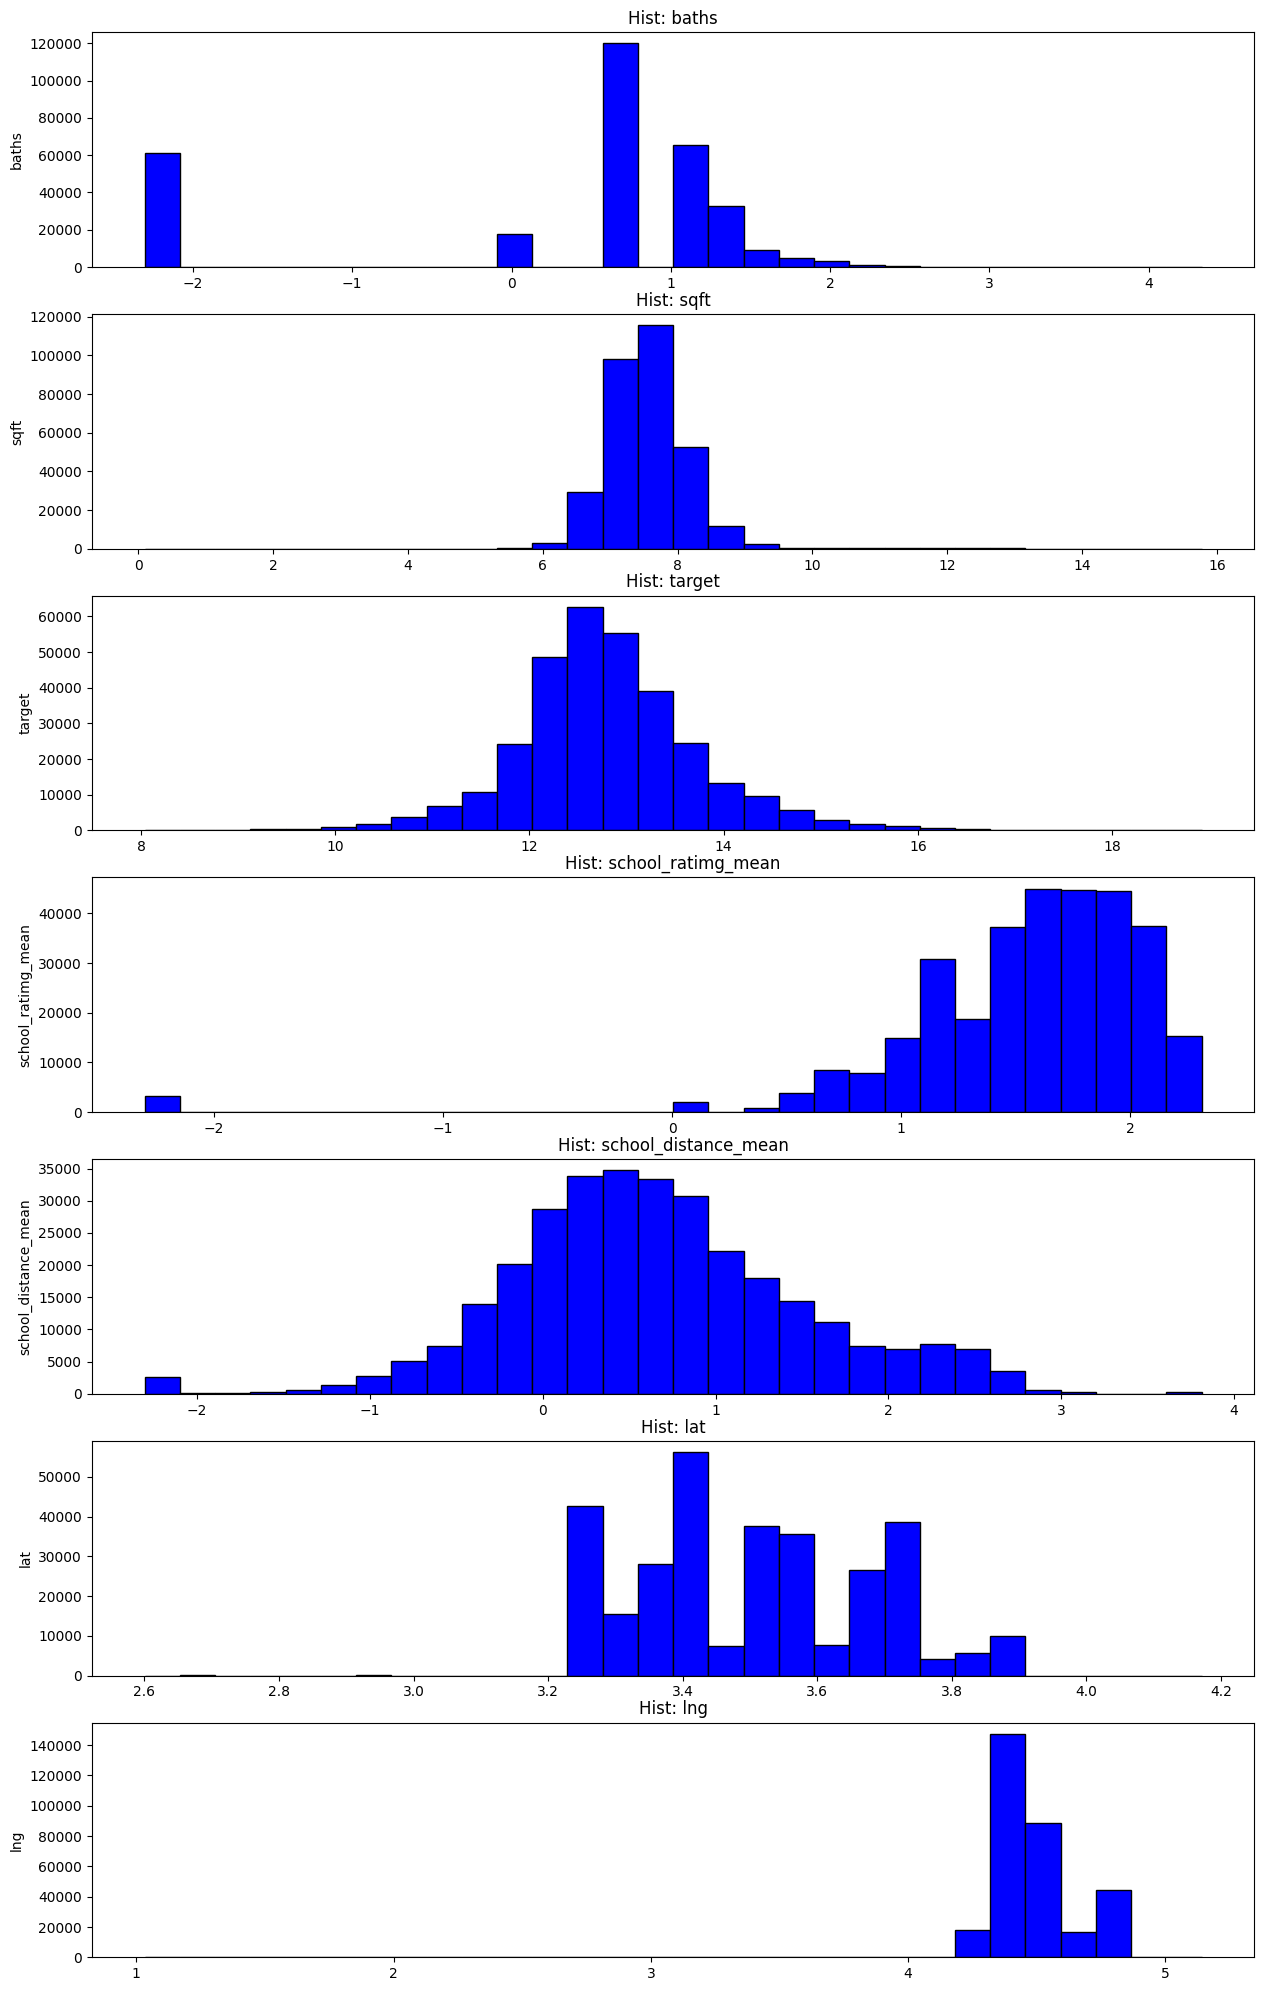

In [189]:
n = len(numfeatures) 
fig, axes = plt.subplots(n, 1, figsize=(15, 25)) # фигура + n х 1 координатных плоскостей
for i, feature in enumerate(numfeatures): #i- индекс, feature - название признака в таблице
    
    axes[i].hist(data1[feature], color = 'blue', edgecolor = 'black', bins = 30)
    axes[i].set_title(f'Hist: {feature}')
    axes[i].set_ylabel(feature)

plt.show()

В результате просто логарифмируем числовые признаки.

In [190]:
data1[numfeatures].describe()

,baths,sqft,target,school_ratimg_mean,school_distance_mean,lat,lng
count,315567.000000,315567.000000,315567.000000,315567.000000,315567.000000,315567.000000,315567.000000
mean,0.331932,7.551983,12.802846,1.544714,0.656893,3.503544,4.501387
std,1.338859,0.619642,0.944194,0.574093,0.852378,0.174369,0.148790
min,-2.302585,0.095310,8.039190,-2.302585,-2.302585,2.600400,1.032643
25%,0.741937,7.170196,12.278394,1.326199,0.117783,3.373671,4.388323
50%,0.741937,7.520831,12.736407,1.629241,0.587787,3.494560,4.437414
75%,1.131402,7.876297,13.296317,1.887070,1.145146,3.664306,4.582329
max,4.332048,15.772583,18.921456,2.312535,3.811761,4.171035,5.140993


In [191]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315567 entries, 0 to 315566
Data columns (total 51 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   baths                                   315567 non-null  float64
 1   fireplace                               315567 non-null  int64  
 2   city                                    315567 non-null  int64  
 3   sqft                                    315567 non-null  float64
 4   zipcode                                 315567 non-null  int64  
 5   state                                   315567 non-null  int64  
 6   target                                  315567 non-null  float64
 7   pool                                    315567 non-null  int64  
 8   Yearbuilt                               315567 non-null  int64  
 9   Heating                                 315567 non-null  int64  
 10  Cooling                                 3155

In [192]:
data1.head()

,baths,fireplace,city,sqft,zipcode,state,target,pool,Yearbuilt,Heating,...,propertyType_highrise,propertyType_land,propertyType_lotland,propertyType_mobilemanufactured,propertyType_multi_family,propertyType_ranch,propertyType_single_family,propertyType_singledetachedtraditional,propertyType_townhouse,propertyType_traditional
0,1.410987,1,1435,7.972500,1057,19,12.943237,0,214,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.131402,0,1445,7.574096,4380,33,12.644328,0,214,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.741937,1,876,8.006401,3530,1,14.878496,1,156,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2.091864,1,368,8.772936,2614,29,14.688894,0,201,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-2.302585,0,1166,6.799167,497,26,12.250090,0,115,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Разделим выборку на тренировочную и тестовую.

In [216]:
y = data1['target'].values
X = data1.drop(['target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

### LinearRegression

In [217]:
result = {'Metric': ['Обучающая выборка MSE', 'Тестовая выборка MSE', 'Обучающая выборка MAE', 'Тестовая выборка MAE', 'Обучающая выборка R2', 'Тестовая выборка R2']}

In [218]:
# создаём модель LinearRegression
model = LinearRegression()
# обучаем модель
model.fit(X_train, y_train)
# делаем предсказания 
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
# вычисляем метрики
mse_train = metrics.mean_squared_error(y_train, y_train_pred)
mse_test = metrics.mean_squared_error(y_test, y_test_pred)
mae_train = metrics.mean_absolute_error(y_train, y_train_pred)
mae_test = metrics.mean_absolute_error(y_test, y_test_pred)
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test = metrics.r2_score(y_test, y_test_pred)
# выводим метрики
print(f"Обучающая выборка MSE: {mse_train:.3f}")
print(f"Тестовая выборка MSE: {mse_test:.3f}")
print(f"Обучающая выборка MAE: {mae_train:.3f}")
print(f"Тестовая выборка MAE: {mae_test:.3f}")
print(f"Обучающая выборка R2: {r2_train:.3f}")
print(f"Тестовая выборка R2: {r2_test:.3f}")

Обучающая выборка MSE: 0.498
Тестовая выборка MSE: 0.500
Обучающая выборка MAE: 0.510
Тестовая выборка MAE: 0.511
Обучающая выборка R2: 0.443
Тестовая выборка R2: 0.437


In [219]:
result['LinearRegression'] = [round(mse_train, 3), round(mse_test, 3), round(mae_train, 3), round(mae_test, 3), round(r2_train, 3), round(r2_test, 3)]

### RandomForestRegressor

In [220]:
# Создаем модель RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=42)
# Обучаем модель
rf_regressor.fit(X_train, y_train)
# делаем предсказания
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)
# Вычисляем метрики
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
# Выводим метрики
print(f"Обучающая выборка MSE: {mse_train:.3f}")
print(f"Тестовая выборка MSE: {mse_test:.3f}")
print(f"Обучающая выборка MAE: {mae_train:.3f}")
print(f"Тестовая выборка MAE: {mae_test:.3f}")
print(f"Обучающая выборка R2: {r2_train:.3f}")
print(f"Тестовая выборка R2: {r2_test:.3f}")

Обучающая выборка MSE: 0.014
Тестовая выборка MSE: 0.098
Обучающая выборка MAE: 0.071
Тестовая выборка MAE: 0.186
Обучающая выборка R2: 0.984
Тестовая выборка R2: 0.889


In [221]:
result['RandomForestRegressor'] = [round(mse_train, 3), round(mse_test, 3), round(mae_train, 3), round(mae_test, 3), round(r2_train, 3), round(r2_test, 3)]

### ElasticNetCV

In [222]:
# Создаем модель ElasticNetCV с кросс-валидацией
el_net = ElasticNetCV(cv=7, random_state=42)
# Обучаем модель
el_net.fit(X_train, y_train)
# делаем предсказания
y_train_pred = el_net.predict(X_train)
y_test_pred = el_net.predict(X_test)
# Вычисляем метрики
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
# Выводим метрики
print(f"Обучающая выборка MSE: {mse_train:.3f}")
print(f"Тестовая выборка MSE: {mse_test:.3f}")
print(f"Обучающая выборка MAE: {mae_train:.3f}")
print(f"Тестовая выборка MAE: {mae_test:.3f}")
print(f"Обучающая выборка R2: {r2_train:.3f}")
print(f"Тестовая выборка R2: {r2_test:.3f}")

Обучающая выборка MSE: 0.608
Тестовая выборка MSE: 0.607
Обучающая выборка MAE: 0.574
Тестовая выборка MAE: 0.573
Обучающая выборка R2: 0.319
Тестовая выборка R2: 0.316


In [223]:
result['ElasticNetCV'] = [round(mse_train, 3), round(mse_test, 3), round(mae_train, 3), round(mae_test, 3), round(r2_train, 3), round(r2_test, 3)]

### LightGBMRegressor

In [227]:
# Обучающая выборка для LightGBM  
train_data = lgb.Dataset(X_train, label=y_train) 
  
# Тестовая выборка для LightGBM 
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data) 

# Параметры для LightGBM regression 
params = { 
    'objective': 'regression', 
    'metric': 'mse', 
    'boosting_type': 'gbdt', 
    'num_leaves': 31, 
    'learning_rate': 0.1, 
    'feature_fraction': 0.9, 
} 
 
num_round = 5000
bst = lgb.train(params, train_data, num_round, valid_sets=[ 
                test_data], early_stopping_rounds=10) 

# делаем предсказания
y_train_pred = bst.predict(X_train)
y_test_pred = bst.predict(X_test)
# Вычисляем метрики
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
# Выводим метрики
print(f"Обучающая выборка MSE: {mse_train:.3f}")
print(f"Тестовая выборка MSE: {mse_test:.3f}")
print(f"Обучающая выборка MAE: {mae_train:.3f}")
print(f"Тестовая выборка MAE: {mae_test:.3f}")
print(f"Обучающая выборка R2: {r2_train:.3f}")
print(f"Тестовая выборка R2: {r2_test:.3f}")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2047
[LightGBM] [Info] Number of data points in the train set: 220896, number of used features: 46
[LightGBM] [Info] Start training from score 12.801520
[1]	valid_0's l2: 0.804842
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.736613
[3]	valid_0's l2: 0.664869
[4]	valid_0's l2: 0.605556
[5]	valid_0's l2: 0.557273
[6]	valid_0's l2: 0.516859
[7]	valid_0's l2: 0.48194
[8]	valid_0's l2: 0.451032
[9]	valid_0's l2: 0.425173
[10]	valid_0's l2: 0.403289
[11]	valid_0's l2: 0.384072
[12]	valid_0's l2: 0.367451
[13]	valid_0's l2: 0.352873
[14]	valid_0's l2: 0.339896
[15]	valid_0's l2: 0.328444
[16]	valid_0's l2: 0.318267
[17]	valid_0's l2: 0.308935
[18]	valid_0's l2: 0.299717
[19]	valid_0's l2: 0.292305
[20]	valid_0's l2: 0.285633
[21]	valid_0's l2: 0.279455
[22]	valid_0's

In [228]:
result['LightGBMRegressor'] = [round(mse_train, 3), round(mse_test, 3), round(mae_train, 3), round(mae_test, 3), round(r2_train, 3), round(r2_test, 3)]

### CatBoostRegressor

In [229]:
data5 = data.copy()
data5['propertyType'] = data5['propertyType'].str.replace(' ', '')
data5 = data5.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
for column in numfeatures:
        
        data5[column] = data5[column].apply(lambda x: abs(x))
        cons = 1e-1
        data5[column] = np.log(data5[column] + cons)
data5.head()

,status,propertyType,baths,fireplace,city,sqft,zipcode,state,target,pool,Yearbuilt,Heating,Cooling,Parking,school_ratimg_mean,school_distance_mean,lat,lng
0,Active,single_family,1.410987,1,Southern Pines,7.972500,28387,NC,12.943237,0,2019,1,0,0,1.667707,1.729441,3.562069,4.375341
1,For Sale,single_family,1.131402,0,Spokane Valley,7.574096,99216,WA,12.644328,0,2019,0,0,0,1.410987,0.355364,3.867018,4.765000
2,For Sale,single_family,0.741937,1,Los Angeles,8.006401,90049,CA,14.878496,1,1961,1,1,1,1.912014,0.722706,3.531394,4.775763
3,For Sale,single_family,2.091864,1,Dallas,8.772936,75205,TX,14.688894,0,2006,1,1,1,2.235376,-0.159582,3.494526,4.573760
4,For Sale,townhouse,-2.302585,0,Philadelphia,6.799167,19145,PA,12.250090,0,1920,1,1,0,-2.302585,-2.302585,3.689703,4.321375


In [230]:
y = data5['target'].values
X = data5.drop(['target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [ ]:
# Параметры для CatBoostRegressor 
param_grid = {
    'iterations': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
}
cbr_model = CatBoostRegressor(random_seed=42, silent=True)
grid_search = GridSearchCV(estimator=cbr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train, cat_features=catfeatures)
best_params = grid_search.best_params_


In [231]:
print('Параметры для CatBoostRegressor', best_params)

Параметры для CatBoostRegressor {'depth': 8, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


In [232]:
best_cbr_model = CatBoostRegressor(iterations=best_params['iterations'], learning_rate=best_params['learning_rate'], depth=best_params['depth'], l2_leaf_reg=best_params['l2_leaf_reg'], random_seed=42, silent=True)
best_cbr_model.fit(X_train, y_train, cat_features=catfeatures)
# делаем предсказания
y_train_pred = best_cbr_model.predict(X_train)
y_test_pred = best_cbr_model.predict(X_test)
# Вычисляем метрики
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
# Выводим метрики
print(f"Обучающая выборка MSE: {mse_train:.3f}")
print(f"Тестовая выборка MSE: {mse_test:.3f}")
print(f"Обучающая выборка MAE: {mae_train:.3f}")
print(f"Тестовая выборка MAE: {mae_test:.3f}")
print(f"Обучающая выборка R2: {r2_train:.3f}")
print(f"Тестовая выборка R2: {r2_test:.3f}")

Обучающая выборка MSE: 0.099
Тестовая выборка MSE: 0.112
Обучающая выборка MAE: 0.212
Тестовая выборка MAE: 0.222
Обучающая выборка R2: 0.889
Тестовая выборка R2: 0.874


In [233]:
result['CatBoostRegressor'] = [round(mse_train, 3), round(mse_test, 3), round(mae_train, 3), round(mae_test, 3), round(r2_train, 3), round(r2_test, 3)]

In [234]:
df_result = pd.DataFrame(result)
df_result.head(6)

,Metric,LinearRegression,RandomForestRegressor,ElasticNetCV,LightGBMRegressor,CatBoostRegressor
0,Обучающая выборка MSE,0.498,0.014,0.608,0.047,0.099
1,Тестовая выборка MSE,0.500,0.098,0.607,0.091,0.112
2,Обучающая выборка MAE,0.510,0.071,0.574,0.148,0.212
3,Тестовая выборка MAE,0.511,0.186,0.573,0.194,0.222
4,Обучающая выборка R2,0.443,0.984,0.319,0.948,0.889
5,Тестовая выборка R2,0.437,0.889,0.316,0.897,0.874


Лучшие результаты показал RandomForestRegressor, однако данный тип моделей склонны к переобучению, LightGBMRegressor
и CatBoostRegressor показали схожие результаты. При этом CatBoostRegresso показал более близкие результаты на тренировочеой и тестовой выборке иr требует меньшей предобработки входных данных за сче 
возможности работы с категориальными признаками. Для работы в веб приложении выбираем CatBoostRegressor.

In [235]:
# Сохранение выбранной обученной модели в файл pickle
with open("web/app/model/model.pkl", "wb") as f:
    pickle.dump(best_cbr_model, f)